In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import json
import os

from scipy.optimize import minimize
from scipy import constants
from scipy.spatial import distance_matrix

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]

from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from utils import *
from random_structures import *
from QUBO_models import *

from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation


def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

eV_to_rad_s = 1.519267447321156e15



## Parameters

In [5]:
T_h = 4.1e-5
C6 = 5.42e-24
reg_coef = [0.0003613877583255407, 0.00020311860082042723]
reg_coef_rad_s  = np.array(reg_coef)*eV_to_rad_s
R_4 = 4.01e-6
R_4_5 = 4.5e-6
R_5 = 5e-6
R_9 = 9e-6
V_max = (C6/(R_4**6))
V_dft = reg_coef[1]*eV_to_rad_s
alpha_v_4 = V_dft/(C6/(R_4**6))
alpha_v_4_5 = V_dft/(C6/(R_4_5**6))
alpha_v_5 = V_dft/(C6/(R_5**6))
alpha_v_9 = V_dft/(C6/(R_9**6))
alpha_v = alpha_v_9
alpha_v*T_h

1.2405765154607304

### Scaling

#### New conc

In [5]:
for i,j in enumerate(np.linspace(125000000, -62500000, 10)):
    print(i,j)

0 125000000.0
1 104166666.66666667
2 83333333.33333334
3 62500000.0
4 41666666.66666667
5 20833333.333333343
6 0.0
7 -20833333.333333313
8 -41666666.66666666
9 -62500000.0


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_3137/1647529790.py:57: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(


236.72868078912074 2.9215809057335366e-05
472.78068424570523 5.834810615627632e-05
889.620266870086 0.00010979225569023905


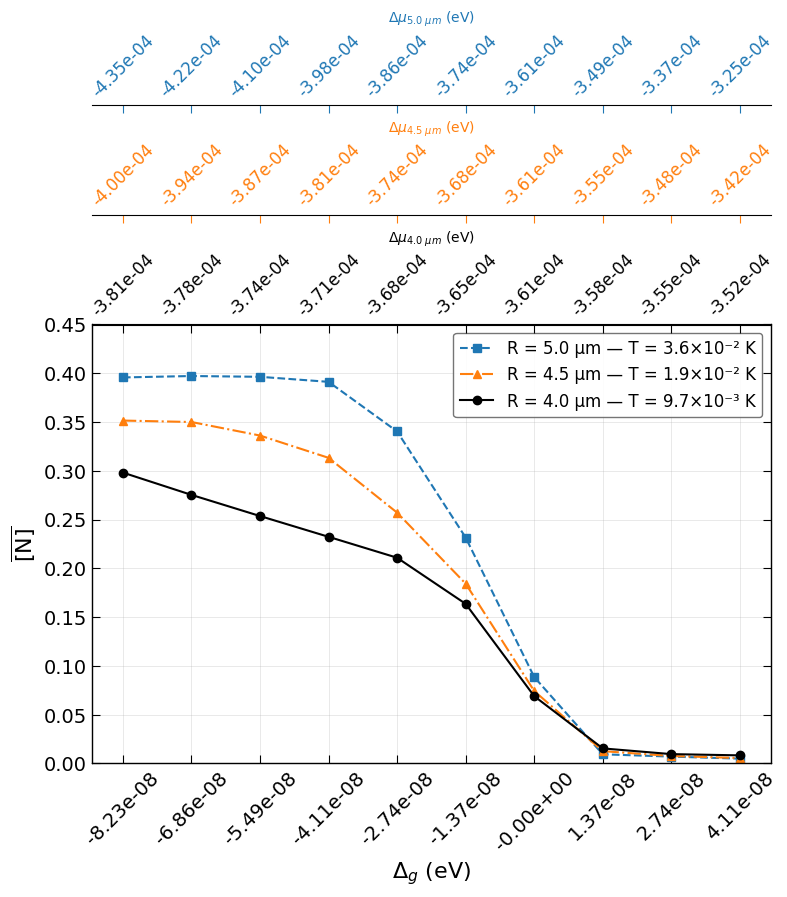

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Load and preprocess data ===
folder_4   = 'qpu_data/production/6x6/4micron'
folder_4_5 = 'qpu_data/production/6x6/4.5micron'
folder_5   = 'qpu_data/production/6x6/5micron'

delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)

def load_hardware_data(folder):
    datasets = []
    delta_mu_vals = []
    for delta_g_idx in range(10):
        path = os.path.join(folder, str(delta_g_idx))
        preseqs, postseqs = read_all_sequences_from_folder(path)
        datasets.append((preseqs, postseqs, f"Δg = {delta_g_idx}"))

        delta_g = -extract_detuning_values(path)[-1]
        delta_mu = (-reg_coef_rad_s[0] + delta_g * alpha_v)  # optional conversion later
        delta_mu_vals.append(delta_mu)
    return datasets, delta_mu_vals

# --- Load all datasets ---
datasets_4,   delta_mu_vals_4   = load_hardware_data(folder_4)
datasets_4_5, delta_mu_vals_4_5 = load_hardware_data(folder_4_5)
datasets_5,   delta_mu_vals_5   = load_hardware_data(folder_5)

# --- Compute Hamming averages ---
def compute_hamming_stats(datasets):
    hamming_avg_all, hamming_std_all = [], []
    for preseqs, postseqs, label in datasets:
        _, hamming_avg, hamming_std, *_ = get_hamming(preseqs, postseqs)
        hamming_avg_all.append(hamming_avg)
        hamming_std_all.append(hamming_std)
    return np.array(hamming_avg_all), np.array(hamming_std_all)

hamming_avg_4,   hamming_std_4   = compute_hamming_stats(datasets_4)
hamming_avg_4_5, hamming_std_4_5 = compute_hamming_stats(datasets_4_5)
hamming_avg_5,   hamming_std_5   = compute_hamming_stats(datasets_5)

# =====================================================
# Plot
# =====================================================
fig, ax = plt.subplots(figsize=(8, 6))

# Convert Δg to eV units (for x-axis)
x_vals = delta_g_all_int_neg / eV_to_rad_s

# Plot the 3 datasets
ax.plot(
    x_vals, hamming_avg_5 / 78,
    's--', label='R = 5.0 µm — T = 3.6×10⁻² K', color='tab:blue'
)

ax.plot(
    x_vals, hamming_avg_4_5 / 78,
    '^-', linestyle='-.', label='R = 4.5 µm — T = 1.9×10⁻² K', color='tab:orange'
)
ax.plot(
    x_vals, hamming_avg_4 / 78,
    'o-', label='R = 4.0 µm — T = 9.7×10⁻³ K', color='k'
)

# =====================================================
# Axes, labels, and formatting
# =====================================================
ax.set_xlabel(r"$\Delta_g$ (eV)", fontsize=16)
ax.set_ylabel(r"$\overline{[\text{N}]}$", fontsize=16)
ax.set_ylim([0, 0.4])

# Set same x ticks and formatting as in your previous plots
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.tick_params(
    axis='both', which='both',
    direction='in', top=True, right=True,
    labelsize=14, length=6
)
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

# Add legend — same aesthetic as before
ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

# Set x limits with padding
xmin = x_vals.min() - 0.05 * (x_vals.max() - x_vals.min())
xmax = x_vals.max() + 0.05 * (x_vals.max() - x_vals.min())
ax.set_xlim(xmin, xmax)
ax.set_ylim(0,0.45)
ax.set_xticks(x_vals)
ax.set_xticklabels([f"{x:.2e}" for x in x_vals],rotation=45)
ax.grid(True, axis='x', which='both', linewidth=0.5, alpha=0.4)
plt.tight_layout()

# ---- helper to add a colored top axis for one curve ----
def add_mu_top_axis(ax_base, x_vals_bottom, delta_g_rad_s, alpha_v, reg0_rad_s,
                    eV_to_rad_s, color, y_offset_axes=1.0, label=r"$\Delta\mu$ (eV)"):
    """
    ax_base: the main axes
    x_vals_bottom: tick positions on the bottom axis (Δg/eV_to_rad_s)
    delta_g_rad_s: the actual hardware Δg for those points (rad/s), same order as x_vals_bottom
    alpha_v, reg0_rad_s: calibration for this curve
    eV_to_rad_s: unit conversion
    color: tick/label color to match the line
    y_offset_axes: where to place this extra axis (1.00=top of axes; >1 stacks above)
    """
    # map Δg -> Δμ
    delta_mu = (-reg0_rad_s + alpha_v * delta_g_rad_s) / eV_to_rad_s  # eV
    print(alpha_v,delta_mu[-1]-delta_mu[0])
    # make a new twiny and lift it slightly above the previous one
    ax_top = ax_base.twiny()
    ax_top.set_xlim(ax_base.get_xlim())
    ax_top.set_xticks(x_vals_bottom)
    ax_top.set_xticklabels([f"{m:.2e}" for m in delta_mu], rotation=45)

    # move this spine upward (stacking multiple top axes)
    ax_top.spines["top"].set_position(("axes", y_offset_axes))
    ax_top.tick_params(axis='x', colors=color, direction='in', length=6, labelsize=12,rotation=45)
    ax_top.xaxis.label.set_color(color)
    ax_top.grid(False)
    ax_top.set_xlabel(label, labelpad=6)
    return ax_top

# ---- build Δg (rad/s) arrays that correspond to your bottom ticks ----
# you already have bottom ticks as x_vals = delta_g_all_int_neg / eV_to_rad_s
delta_g_rad_s_points = x_vals * eV_to_rad_s  # same for all since bottom ticks use common Δg values

# If each curve has different calibration, specify them here; otherwise reuse the same.
(alpha_4, reg0_4)     = (alpha_v_4, reg_coef_rad_s[0])
(alpha_4_5, reg0_4_5) = (alpha_v_4_5, reg_coef_rad_s[0])
(alpha_5, reg0_5)     = (alpha_v_5, reg_coef_rad_s[0])

# stack three colored top axes (slightly separated vertically)
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_4,   reg0_4,   eV_to_rad_s, color='k',          y_offset_axes=1.00, label=r"$\Delta\mu_{4.0\ \mu m}$ (eV)")
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_4_5, reg0_4_5, eV_to_rad_s, color='tab:orange', y_offset_axes=1.25, label=r"$\Delta\mu_{4.5\ \mu m}$ (eV)")
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_5,   reg0_5,   eV_to_rad_s, color='tab:blue',   y_offset_axes=1.5, label=r"$\Delta\mu_{5.0\ \mu m}$ (eV)")

plt.show()

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_3137/3113469493.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(


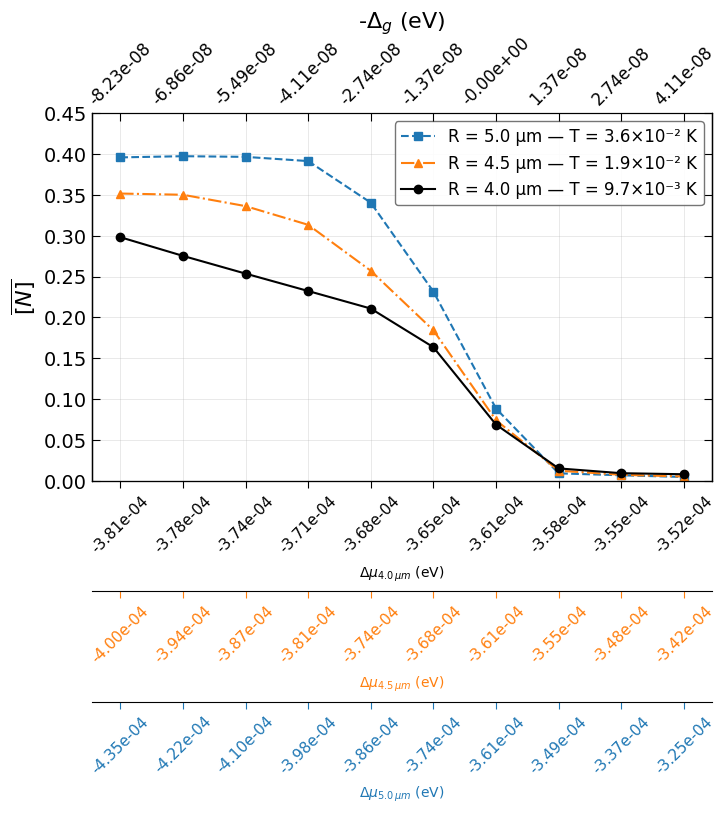

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Load and preprocess data ===
folder_4   = 'qpu_data/production/6x6/4micron'
folder_4_5 = 'qpu_data/production/6x6/4.5micron'
folder_5   = 'qpu_data/production/6x6/5micron'

delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)

def load_hardware_data(folder):
    datasets = []
    delta_mu_vals = []
    for delta_g_idx in range(10):
        path = os.path.join(folder, str(delta_g_idx))
        preseqs, postseqs = read_all_sequences_from_folder(path)
        datasets.append((preseqs, postseqs, f"Δg = {delta_g_idx}"))

        delta_g = -extract_detuning_values(path)[-1]
        delta_mu = (-reg_coef_rad_s[0] + delta_g * alpha_v)
        delta_mu_vals.append(delta_mu)
    return datasets, delta_mu_vals

datasets_4,   delta_mu_vals_4   = load_hardware_data(folder_4)
datasets_4_5, delta_mu_vals_4_5 = load_hardware_data(folder_4_5)
datasets_5,   delta_mu_vals_5   = load_hardware_data(folder_5)

def compute_hamming_stats(datasets):
    hamming_avg_all, hamming_std_all = [], []
    for preseqs, postseqs, label in datasets:
        _, hamming_avg, hamming_std, *_ = get_hamming(preseqs, postseqs)
        hamming_avg_all.append(hamming_avg)
        hamming_std_all.append(hamming_std)
    return np.array(hamming_avg_all), np.array(hamming_std_all)

hamming_avg_4,   hamming_std_4   = compute_hamming_stats(datasets_4)
hamming_avg_4_5, hamming_std_4_5 = compute_hamming_stats(datasets_4_5)
hamming_avg_5,   hamming_std_5   = compute_hamming_stats(datasets_5)

# =====================================================
# Main figure
# =====================================================
fig, ax = plt.subplots(figsize=(8, 8))

x_vals = delta_g_all_int_neg / eV_to_rad_s

ax.plot(
    x_vals, hamming_avg_5 / 78,
    's--', label='R = 5.0 µm — T = 3.6×10⁻² K', color='tab:blue'
)
ax.plot(
    x_vals, hamming_avg_4_5 / 78,
    '^-', linestyle='-.', label='R = 4.5 µm — T = 1.9×10⁻² K', color='tab:orange'
)
ax.plot(
    x_vals, hamming_avg_4 / 78,
    'o-', label='R = 4.0 µm — T = 9.7×10⁻³ K', color='k'
)

ax.set_ylabel(r"$\overline{[N]}$", fontsize=16)
ax.set_ylim(0, 0.45)
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

ax.tick_params(axis='both', which='both',
               direction='in', top=True, right=True,
               labelsize=14, length=6)

ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

# we’ll use x_vals as the reference ticks everywhere
ax.set_xticks(x_vals)
ax.set_xticklabels([])     # bottom labels will be added via extra axes
ax.tick_params(axis='x', length=0)

# =====================================================
# Top axis: Δg (eV) – same as before
# =====================================================
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(x_vals)
ax_top.set_xticklabels([f"{x:.2e}" for x in x_vals], rotation=45, ha='center')
ax_top.set_xlabel(r"-$\Delta_g$ (eV)", fontsize=16)
ax_top.tick_params(axis='x', direction='in', top=True, length=6, labelsize=12)

# =====================================================
# Helper: add one bottom Δμ axis (using same logic as old top-axes code)
# =====================================================
def add_mu_bottom_axis(ax_base, x_vals_bottom, delta_g_rad_s, alpha_v, reg0_rad_s,
                       eV_to_rad_s, color, y_offset_axes= -0.2,
                       label=r"$\Delta\mu$ (eV)"):
    """
    Create one coloured bottom Δμ axis, with tick labels rotated by 45°.
    """
    delta_mu = (-reg0_rad_s + alpha_v * delta_g_rad_s) / eV_to_rad_s  # eV

    ax_bottom = ax_base.twiny()
    ax_bottom.set_xlim(ax_base.get_xlim())
    ax_bottom.set_xticks(x_vals_bottom)
    ax_bottom.set_xticklabels([f"{m:.2e}" for m in delta_mu], rotation=45)

    # place this spine below the main axes
    ax_bottom.spines["bottom"].set_position(("axes", y_offset_axes))
    ax_bottom.xaxis.set_ticks_position("bottom")
    ax_bottom.xaxis.set_label_position("bottom")

    # Apply colour + rotation style
    ax_bottom.tick_params(axis='x',
                          colors=color,
                          direction='out',
                          length=5,
                          labelsize=11,
                          labelrotation=45)

    ax_bottom.xaxis.label.set_color(color)
    ax_bottom.grid(False)
    ax_bottom.set_xlabel(label, labelpad=6)

    # hide the unused top spine
    ax_bottom.spines["top"].set_visible(False)

    return ax_bottom

# =====================================================
# Build Δg (rad/s) array corresponding to x_vals
# =====================================================
delta_g_rad_s_points = x_vals * eV_to_rad_s

(alpha_4,   reg0_4)   = (alpha_v_4,   reg_coef_rad_s[0])
(alpha_4_5, reg0_4_5) = (alpha_v_4_5, reg_coef_rad_s[0])
(alpha_5,   reg0_5)   = (alpha_v_5,   reg_coef_rad_s[0])

# Three bottom Δμ axes, clearly separated
add_mu_bottom_axis(
    ax, x_vals, delta_g_rad_s_points,
    alpha_4, reg0_4, eV_to_rad_s,
    color='k',
    y_offset_axes=-0.0,
    label=r"$\Delta\mu_{4.0\,\mu m}$ (eV)"
)
add_mu_bottom_axis(
    ax, x_vals, delta_g_rad_s_points,
    alpha_4_5, reg0_4_5, eV_to_rad_s,
    color='tab:orange',
    y_offset_axes=-0.30,
    label=r"$\Delta\mu_{4.5\,\mu m}$ (eV)"
)
add_mu_bottom_axis(
    ax, x_vals, delta_g_rad_s_points,
    alpha_5, reg0_5, eV_to_rad_s,
    color='tab:blue',
    y_offset_axes=-0.60,
    label=r"$\Delta\mu_{5.0\,\mu m}$ (eV)"
)

# give space at the bottom for the stacked axes
plt.subplots_adjust(bottom=0.42)

plt.show()

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_3137/1534718616.py:92: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(


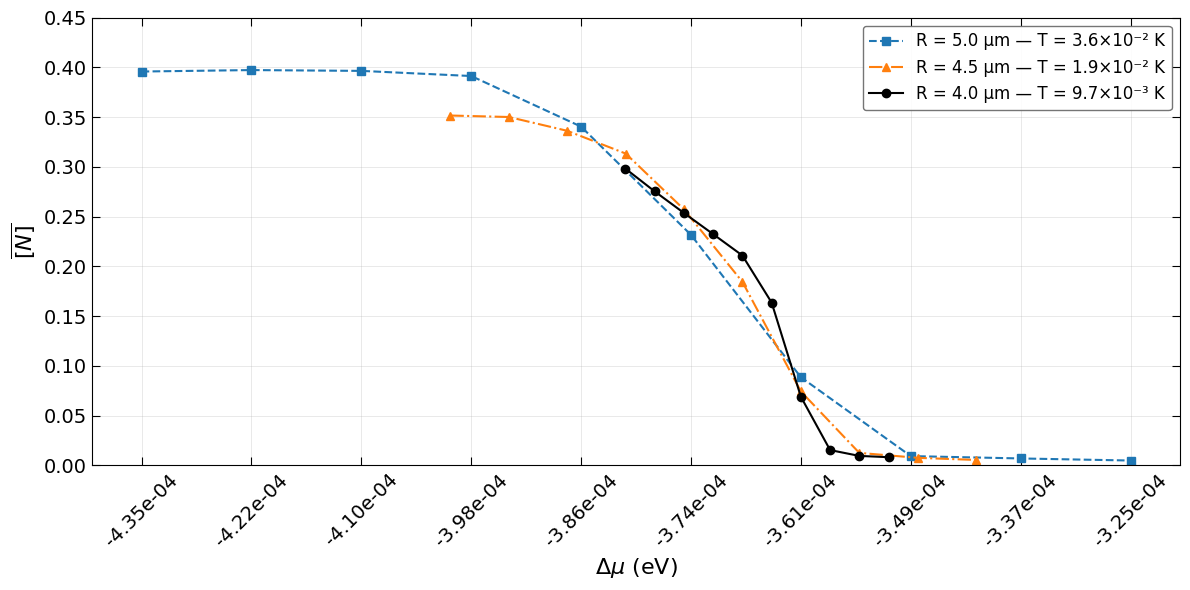

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Load and preprocess data ===
folder_4   = 'qpu_data/production/6x6/4micron'
folder_4_5 = 'qpu_data/production/6x6/4.5micron'
folder_5   = 'qpu_data/production/6x6/5micron'

delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)   # rad/s

def load_hardware_data(folder, alpha_v, reg_coef_rad_s):
    datasets = []
    delta_mu_vals = []

    for delta_g_idx in range(10):
        path = os.path.join(folder, str(delta_g_idx))

        preseqs, postseqs = read_all_sequences_from_folder(path)
        datasets.append((preseqs, postseqs, f"Δg = {delta_g_idx}"))

        delta_g = -extract_detuning_values(path)[-1]  # rad/s

        # Δμ for THIS radius
        delta_mu = -reg_coef_rad_s[0] + delta_g * alpha_v
        delta_mu_vals.append(delta_mu)

    return datasets, np.array(delta_mu_vals, dtype=float)


def compute_hamming_stats(datasets):
    hamming_avg_all, hamming_std_all = [], []
    for preseqs, postseqs, label in datasets:
        _, hamming_avg, hamming_std, *_ = get_hamming(preseqs, postseqs)
        hamming_avg_all.append(hamming_avg)
        hamming_std_all.append(hamming_std)
    return np.array(hamming_avg_all), np.array(hamming_std_all)


# --- Load data for each radius ---
datasets_4,   delta_mu_vals_4   = load_hardware_data(folder_4,   alpha_v_4,   reg_coef_rad_s)
datasets_4_5, delta_mu_vals_4_5 = load_hardware_data(folder_4_5, alpha_v_4_5, reg_coef_rad_s)
datasets_5,   delta_mu_vals_5   = load_hardware_data(folder_5,   alpha_v_5,   reg_coef_rad_s)

hamming_avg_4,   _ = compute_hamming_stats(datasets_4)
hamming_avg_4_5, _ = compute_hamming_stats(datasets_4_5)
hamming_avg_5,   _ = compute_hamming_stats(datasets_5)


# =====================================================
# Convert Δμ to eV for each radius
# =====================================================
x_mu_4   = delta_mu_vals_4   / eV_to_rad_s
x_mu_45  = delta_mu_vals_4_5 / eV_to_rad_s
x_mu_5   = delta_mu_vals_5   / eV_to_rad_s

# =====================================================
# SORT the 5 µm curve — this defines the TICK POSITIONS
# =====================================================
order5 = np.argsort(x_mu_5)

x_mu_5_sorted   = x_mu_5[order5]
y_5_sorted      = (hamming_avg_5 / 78)[order5]
delta_g_sorted  = delta_g_all_int_neg[order5]    # needed for top axis

# -----------------------------------------------------
# Sort the other radii by THEIR OWN Δμ for clean curves
# -----------------------------------------------------
order4 = np.argsort(x_mu_4)
x_mu_4_sorted  = x_mu_4[order4]
y_4_sorted     = (hamming_avg_4 / 78)[order4]

order45 = np.argsort(x_mu_45)
x_mu_45_sorted = x_mu_45[order45]
y_45_sorted    = (hamming_avg_4_5 / 78)[order45]


# Top-axis values: convert -Δg → eV
x_g_labels_eV = -delta_g_sorted / eV_to_rad_s


# =====================================================
# Plot
# =====================================================
fig, ax = plt.subplots(figsize=(12, 6))

# ---------- plot each radius vs its OWN Δμ ----------
ax.plot(
    x_mu_5_sorted, y_5_sorted,
    's--', label='R = 5.0 µm — T = 3.6×10⁻² K', color='tab:blue'
)
ax.plot(
    x_mu_45_sorted, y_45_sorted,
    '^-', linestyle='-.', label='R = 4.5 µm — T = 1.9×10⁻² K', color='tab:orange'
)
ax.plot(
    x_mu_4_sorted, y_4_sorted,
    'o-', label='R = 4.0 µm — T = 9.7×10⁻³ K', color='k'
)

ax.set_ylabel(r"$\overline{[N]}$", fontsize=16)
ax.set_ylim(0, 0.45)
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

ax.tick_params(axis='both', which='both',
               direction='in', top=True, right=True,
               labelsize=14, length=6)

ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

# =====================================================
# Bottom axis: Δμ for 5 µm (ticks + labels)
# =====================================================
ax.set_xlabel(r"$\Delta\mu$ (eV)", fontsize=16)
ax.set_xticks(x_mu_5_sorted)
ax.set_xticklabels([f"{v:.2e}" for v in x_mu_5_sorted], rotation=45, ha='center')

# =====================================================
# Top axis: −Δg (eV) corresponding to the same detunings
# =====================================================
# ax_top = ax.twiny()
# ax_top.set_xlim(ax.get_xlim())
# ax_top.set_xticks(x_mu_5_sorted)
# ax_top.set_xticklabels([f"{g:.2e}" for g in x_g_labels_eV], rotation=45, ha='right')

# ax_top.set_xlabel(r"-$\Delta_g$ (eV)", fontsize=16)
# ax_top.tick_params(axis='x',
#                    direction='in',
#                    top=True,
#                    labelsize=12,
#                    length=6)
# ax_top.grid(False)

plt.tight_layout()
plt.show()

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_92920/2200955052.py:125: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x_mu_45_s, y_45_s, '^-',  color='tab:orange', linestyle='-.', label='R = 4.5 µm — T = 1.9×10⁻² K')


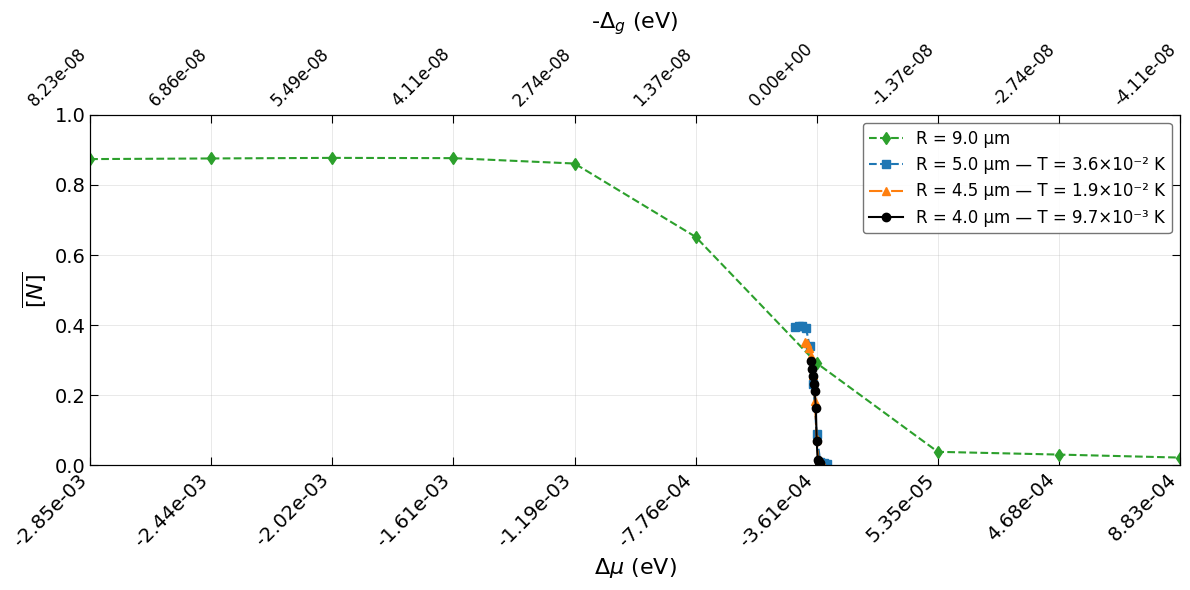

Δμ ranges (eV):
  R=4.0 µm: -0.00038086496436376426 -0.0003516491553064289
  R=4.5 µm: -0.0004002864957630583 -0.00034193838960678197
  R=5.0 µm: -0.00043458259545236676 -0.0003247903397621277
  R=9.0 µm: -0.002850906954326663 0.0008833718396750206


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# CONFIG
# =====================================================
folder_4   = 'qpu_data/production/6x6/4micron'
folder_4_5 = 'qpu_data/production/6x6/4.5micron'
folder_5   = 'qpu_data/production/6x6/5micron'
folder_9   = 'qpu_data/production/6x6/9micron'

# Your 10 detuning points in hardware units (rad/s)
delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)   # rad/s

# NOTE: this script assumes these exist in your environment:
#   - read_all_sequences_from_folder(path)
#   - extract_detuning_values(path)
#   - get_hamming(preseqs, postseqs)
#   - eV_to_rad_s
#   - reg_coef_rad_s  (array-like; reg_coef_rad_s[0] is reg0 in rad/s)
#   - alpha_v_4, alpha_v_4_5, alpha_v_5, alpha_v_9


# =====================================================
# LOADERS
# =====================================================
def load_hardware_data(folder, alpha_v, reg_coef_rad_s):
    """
    For idx=0..9:
      - loads pre/post sequences
      - reads hardware detuning Δg (rad/s) with your sign convention
      - computes Δμ (rad/s) using this radius' alpha_v
    Returns:
      datasets: list of (preseqs, postseqs, label)
      delta_mu_vals: np.ndarray of Δμ (rad/s), length 10
      delta_g_vals : np.ndarray of Δg (rad/s), length 10
    """
    datasets = []
    delta_mu_vals = []
    delta_g_vals  = []

    for delta_g_idx in range(10):
        path = os.path.join(folder, str(delta_g_idx))

        preseqs, postseqs = read_all_sequences_from_folder(path)
        datasets.append((preseqs, postseqs, f"Δg idx={delta_g_idx}"))

        # hardware Δg (rad/s) with your sign convention used elsewhere
        delta_g = -extract_detuning_values(path)[-1]
        delta_g_vals.append(delta_g)

        # Δμ in rad/s (radius-dependent calibration)
        delta_mu = -reg_coef_rad_s[0] + delta_g * alpha_v
        delta_mu_vals.append(delta_mu)

    return datasets, np.array(delta_mu_vals, dtype=float), np.array(delta_g_vals, dtype=float)


def compute_hamming_avg(datasets):
    """
    Returns Hamming average per detuning index, as an array.
    """
    hamming_avg_all = []
    for preseqs, postseqs, _ in datasets:
        _, hamming_avg, _, *_ = get_hamming(preseqs, postseqs)
        hamming_avg_all.append(hamming_avg)
    return np.array(hamming_avg_all, dtype=float)


# =====================================================
# MAIN
# =====================================================
# --- Load data for each radius ---
datasets_4,  dmu_4_rad_s,  dg_4_rad_s  = load_hardware_data(folder_4,  alpha_v_4,  reg_coef_rad_s)
datasets_45, dmu_45_rad_s, dg_45_rad_s = load_hardware_data(folder_4_5, alpha_v_4_5, reg_coef_rad_s)
datasets_5,  dmu_5_rad_s,  dg_5_rad_s  = load_hardware_data(folder_5,  alpha_v_5,  reg_coef_rad_s)
datasets_9,  dmu_9_rad_s,  dg_9_rad_s  = load_hardware_data(folder_9,  alpha_v_9,  reg_coef_rad_s)

# --- Hamming averages ---
havg_4  = compute_hamming_avg(datasets_4)
havg_45 = compute_hamming_avg(datasets_45)
havg_5  = compute_hamming_avg(datasets_5)
havg_9  = compute_hamming_avg(datasets_9)

# --- Convert Δμ to eV for plotting on x-axis ---
x_mu_4  = dmu_4_rad_s  / eV_to_rad_s
x_mu_45 = dmu_45_rad_s / eV_to_rad_s
x_mu_5  = dmu_5_rad_s  / eV_to_rad_s
x_mu_9  = dmu_9_rad_s  / eV_to_rad_s

# --- y-values as concentration fraction ---
y_4  = havg_4  / 78.0
y_45 = havg_45 / 78.0
y_5  = havg_5  / 78.0
y_9  = havg_9  / 78.0

# =====================================================
# SORTING
#   - Each curve sorted by its OWN Δμ for a clean line
#   - Ticks/labels come ONLY from the 9 µm curve
# =====================================================
ord4  = np.argsort(x_mu_4)
ord45 = np.argsort(x_mu_45)
ord5  = np.argsort(x_mu_5)
ord9  = np.argsort(x_mu_9)

x_mu_4_s,  y_4_s  = x_mu_4[ord4],   y_4[ord4]
x_mu_45_s, y_45_s = x_mu_45[ord45], y_45[ord45]
x_mu_5_s,  y_5_s  = x_mu_5[ord5],   y_5[ord5]
x_mu_9_s,  y_9_s  = x_mu_9[ord9],   y_9[ord9]

# For top-axis labels we need the Δg corresponding to the *tick* points (i.e. 9 µm detunings)
dg_9_for_ticks = dg_9_rad_s[ord9]
x_g_labels_eV  = -dg_9_for_ticks / eV_to_rad_s   # top axis label values (eV)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12, 6))

# Curves
ax.plot(x_mu_9_s,  y_9_s,  'd--', color='tab:green',  label='R = 9.0 µm')
ax.plot(x_mu_5_s,  y_5_s,  's--', color='tab:blue',   label='R = 5.0 µm — T = 3.6×10⁻² K')
ax.plot(x_mu_45_s, y_45_s, '^-',  color='tab:orange', linestyle='-.', label='R = 4.5 µm — T = 1.9×10⁻² K')
ax.plot(x_mu_4_s,  y_4_s,  'o-',  color='k',          label='R = 4.0 µm — T = 9.7×10⁻³ K')

# Y axis
ax.set_ylabel(r"$\overline{[N]}$", fontsize=16)
ax.set_ylim(0, 1.)

# Grid + ticks style
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)
ax.tick_params(axis='both', which='both',
               direction='in', top=True, right=True,
               labelsize=14, length=6)

ax.legend(loc='best', fontsize=12, frameon=True,
          facecolor='white', edgecolor='0.4', framealpha=0.9)

# =====================================================
# Bottom axis: Δμ ticks from 9 µm ONLY
# =====================================================
ax.set_xlabel(r"$\Delta\mu$ (eV)", fontsize=16)

ax.set_xticks(x_mu_9_s)
ax.set_xticklabels([f"{v:.2e}" for v in x_mu_9_s], rotation=45, ha='right')

# IMPORTANT: set x-limits from the 9 µm range (so the ticks make sense visually)
ax.set_xlim(x_mu_9_s.min(), x_mu_9_s.max())

# =====================================================
# Top axis: −Δg (eV) corresponding to the SAME detuning points as 9 µm ticks
# =====================================================
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())

ax_top.set_xticks(x_mu_9_s)
ax_top.set_xticklabels([f"{g:.2e}" for g in x_g_labels_eV], rotation=45, ha='right')

ax_top.set_xlabel(r"-$\Delta_g$ (eV)", fontsize=16, labelpad=8)
ax_top.tick_params(axis='x', which='both',
                   direction='in', top=True,
                   labelsize=12, length=6)
ax_top.grid(False)

plt.tight_layout()
plt.show()

# =====================================================
# OPTIONAL DEBUG (helpful to confirm the “unit”/scale issue)
# =====================================================
print("Δμ ranges (eV):")
print("  R=4.0 µm:",  float(np.min(x_mu_4)),  float(np.max(x_mu_4)))
print("  R=4.5 µm:",  float(np.min(x_mu_45)), float(np.max(x_mu_45)))
print("  R=5.0 µm:",  float(np.min(x_mu_5)),  float(np.max(x_mu_5)))
print("  R=9.0 µm:",  float(np.min(x_mu_9)),  float(np.max(x_mu_9)))

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_92920/4171526125.py:64: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(dg_45_eV_sorted, dmu_45_sorted, '^-', linestyle='-.', color='tab:orange', label='R = 4.5 µm')


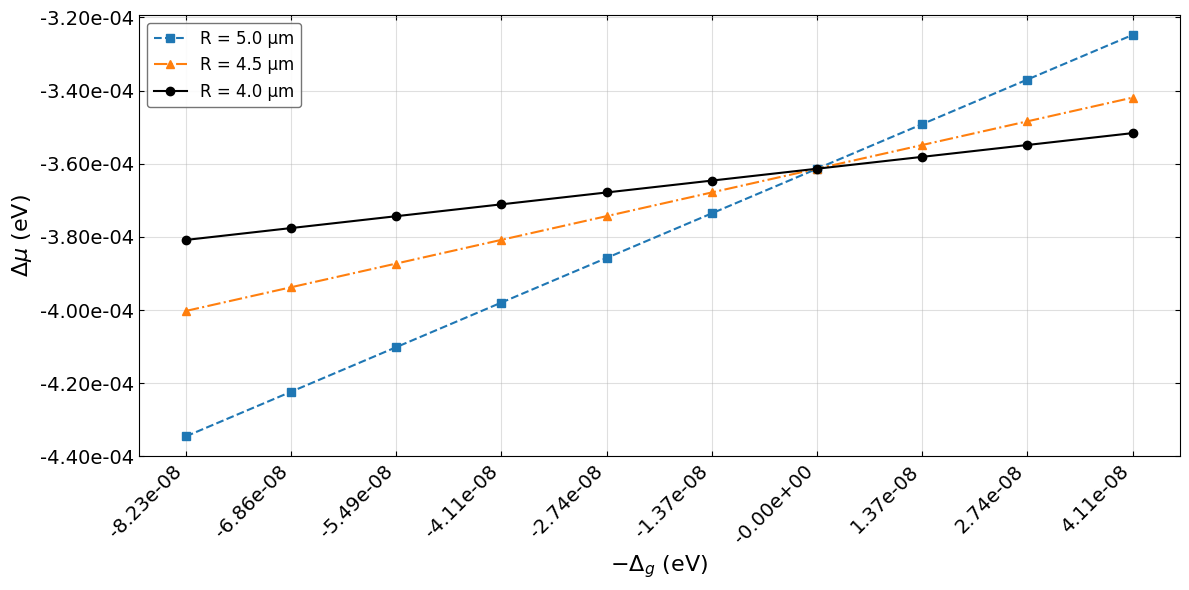

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator

# ------------------------------------------------------------
# Helper: load Δg and Δμ for one radius
# ------------------------------------------------------------
def load_delta_mu_vs_delta_g(folder, alpha_v, reg_coef_rad_s, eV_to_rad_s):
    delta_g_list = []
    delta_mu_list = []

    for idx in range(10):
        path = os.path.join(folder, str(idx))

        # hardware Δg (rad/s)
        delta_g = extract_detuning_values(path)[-1]
        delta_g_list.append(delta_g)

        # Δμ (eV)
        delta_mu = (-reg_coef_rad_s[0] + alpha_v * -delta_g) / eV_to_rad_s
        delta_mu_list.append(delta_mu)

    return np.array(delta_g_list), np.array(delta_mu_list)


# ------------------------------------------------------------
# Load for each radius
# (assumes folder_4, folder_4_5, folder_5, alpha_v_4, alpha_v_4_5, alpha_v_5,
#  reg_coef_rad_s, eV_to_rad_s are already defined in your notebook)
# ------------------------------------------------------------
dg_4,  dmu_4  = load_delta_mu_vs_delta_g(folder_4,   alpha_v_4,   reg_coef_rad_s, eV_to_rad_s)
dg_45, dmu_45 = load_delta_mu_vs_delta_g(folder_4_5, alpha_v_4_5, reg_coef_rad_s, eV_to_rad_s)
dg_5,  dmu_5  = load_delta_mu_vs_delta_g(folder_5,   alpha_v_5,   reg_coef_rad_s, eV_to_rad_s)

# Convert Δg to eV (with minus sign)
dg_4_eV  = -dg_4  / eV_to_rad_s
dg_45_eV = -dg_45 / eV_to_rad_s
dg_5_eV  = -dg_5  / eV_to_rad_s

# Sort each curve by Δg so the lines look nice
ord4   = np.argsort(dg_4_eV)
ord45  = np.argsort(dg_45_eV)
ord5   = np.argsort(dg_5_eV)

dg_4_eV_sorted  = dg_4_eV[ord4]
dmu_4_sorted    = dmu_4[ord4]

dg_45_eV_sorted = dg_45_eV[ord45]
dmu_45_sorted   = dmu_45[ord45]

dg_5_eV_sorted  = dg_5_eV[ord5]
dmu_5_sorted    = dmu_5[ord5]

# Use 5 µm Δg values as x-tick positions (as you requested)
tick_positions = dg_5_eV_sorted

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dg_5_eV_sorted,  dmu_5_sorted,  's--', color='tab:blue',   label='R = 5.0 µm')
ax.plot(dg_45_eV_sorted, dmu_45_sorted, '^-', linestyle='-.', color='tab:orange', label='R = 4.5 µm')
ax.plot(dg_4_eV_sorted,  dmu_4_sorted,  'o-', color='k',           label='R = 4.0 µm')

ax.set_xlabel(r"$-\Delta_g$ (eV)", fontsize=16)
ax.set_ylabel(r"$\Delta\mu$ (eV)", fontsize=16)

# ------------------------------------------------------------
# Custom scientific-notation tick formatting (no offsets)
# ------------------------------------------------------------

def sci_fmt(x, pos):
    return f"{x:.2e}"

# X axis: ticks at 5 µm Δg positions, formatted in sci notation
ax.xaxis.set_major_locator(FixedLocator(tick_positions))
ax.xaxis.set_major_formatter(FuncFormatter(sci_fmt))

# Y axis: keep Matplotlib's automatic tick positions, but format in sci notation
ax.yaxis.set_major_formatter(FuncFormatter(sci_fmt))

# Hide any offset text just in case
ax.xaxis.offsetText.set_visible(False)
ax.yaxis.offsetText.set_visible(False)

# Rotate x tick labels
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right")

# ------------------------------------------------------------
# Style
# ------------------------------------------------------------
ax.grid(True, which='both', alpha=0.4)
ax.tick_params(axis='both', direction='in', top=True, right=True, labelsize=14)
ax.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='0.4', framealpha=0.9)

plt.tight_layout()
plt.show()

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_92920/2611062855.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x45, dmu_45, '^-',  linestyle='-.', color='tab:orange', label='R = 4.5 µm')


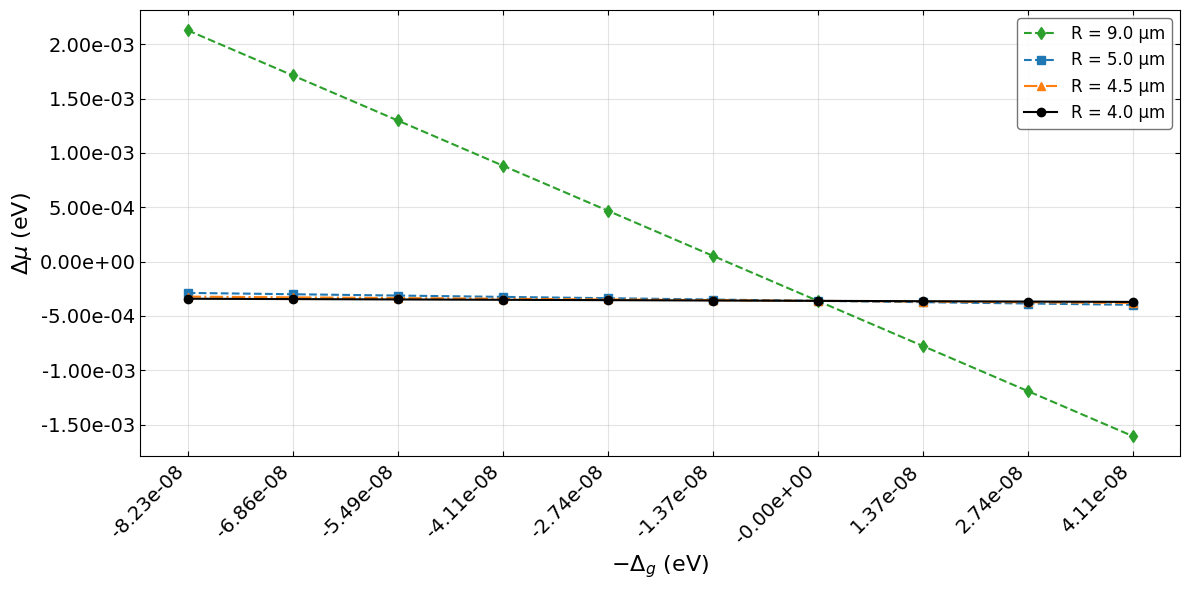

Δμ ranges (eV):
  4.0 µm: -0.00037112636134465244 -0.0003419105522873172
  4.5 µm: -0.00038083712704429953 -0.00032248902088802316
  5.0 µm: -0.00039798517688895374 -0.0002881929211987147
  9.0 µm: -0.001606147356326102 0.002128131437675582


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator

# ------------------------------------------------------------
# Helper: load raw Δg (rad/s) and Δμ (eV)
# ------------------------------------------------------------
def load_delta_mu_vs_delta_g(folder, alpha_v, reg_coef_rad_s, eV_to_rad_s):
    delta_g_raw = []
    delta_mu_eV = []

    for idx in range(10):
        path = os.path.join(folder, str(idx))

        dg = extract_detuning_values(path)[-1]   # RAW hardware Δg (rad/s)
        delta_g_raw.append(dg)

        r0 = reg_coef_rad_s[0]
        dmu = (-r0 + alpha_v * dg) / eV_to_rad_s
        delta_mu_eV.append(dmu)

    return np.array(delta_g_raw), np.array(delta_mu_eV)


# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
dg_4,  dmu_4  = load_delta_mu_vs_delta_g(folder_4,   alpha_v_4,   reg_coef_rad_s, eV_to_rad_s)
dg_45, dmu_45 = load_delta_mu_vs_delta_g(folder_4_5, alpha_v_4_5, reg_coef_rad_s, eV_to_rad_s)
dg_5,  dmu_5  = load_delta_mu_vs_delta_g(folder_5,   alpha_v_5,   reg_coef_rad_s, eV_to_rad_s)
dg_9,  dmu_9  = load_delta_mu_vs_delta_g(folder_9,   alpha_v_9,   reg_coef_rad_s, eV_to_rad_s)

# ------------------------------------------------------------
# Convert to x = -Δg (eV)  ← MINUS SIGN APPLIED ONCE HERE
# ------------------------------------------------------------
x4  = -dg_4  / eV_to_rad_s
x45 = -dg_45 / eV_to_rad_s
x5  = -dg_5  / eV_to_rad_s
x9  = -dg_9  / eV_to_rad_s


def sort_xy(x, y):
    o = np.argsort(x)
    return x[o], y[o]


x4,  dmu_4  = sort_xy(x4,  dmu_4)
x45, dmu_45 = sort_xy(x45, dmu_45)
x5,  dmu_5  = sort_xy(x5,  dmu_5)
x9,  dmu_9  = sort_xy(x9,  dmu_9)

# ------------------------------------------------------------
# Use 9 µm for ticks
# ------------------------------------------------------------
tick_positions = x9

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x9,  dmu_9,  'd--', color='tab:green', label='R = 9.0 µm')
ax.plot(x5,  dmu_5,  's--', color='tab:blue',  label='R = 5.0 µm')
ax.plot(x45, dmu_45, '^-',  linestyle='-.', color='tab:orange', label='R = 4.5 µm')
ax.plot(x4,  dmu_4,  'o-',  color='k', label='R = 4.0 µm')

ax.set_xlabel(r"$-\Delta_g$ (eV)", fontsize=16)
ax.set_ylabel(r"$\Delta\mu$ (eV)", fontsize=16)

# ------------------------------------------------------------
# Scientific notation ticks (no offsets)
# ------------------------------------------------------------
def sci_fmt(x, pos):
    return f"{x:.2e}"

ax.xaxis.set_major_locator(FixedLocator(tick_positions))
ax.xaxis.set_major_formatter(FuncFormatter(sci_fmt))
ax.yaxis.set_major_formatter(FuncFormatter(sci_fmt))

ax.xaxis.offsetText.set_visible(False)
ax.yaxis.offsetText.set_visible(False)

for lbl in ax.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_ha("right")

ax.grid(True, which='major', alpha=0.35)
ax.tick_params(axis='both', direction='in', top=True, right=True, labelsize=14)

ax.legend(
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Sanity check
# ------------------------------------------------------------
print("Δμ ranges (eV):")
print("  4.0 µm:", dmu_4.min(),  dmu_4.max())
print("  4.5 µm:", dmu_45.min(), dmu_45.max())
print("  5.0 µm:", dmu_5.min(),  dmu_5.max())
print("  9.0 µm:", dmu_9.min(),  dmu_9.max())

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Load and preprocess data ===
folder_4   = 'qpu_data/production/6x6/4micron'
folder_4_5 = 'qpu_data/production/6x6/4.5micron'
folder_5   = 'qpu_data/production/6x6/5micron'

delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)

def load_hardware_data(folder):
    datasets = []
    delta_mu_vals = []
    for delta_g_idx in range(10):
        path = os.path.join(folder, str(delta_g_idx))
        preseqs, postseqs = read_all_sequences_from_folder(path)
        datasets.append((preseqs, postseqs, f"Δg = {delta_g_idx}"))

        delta_g = -extract_detuning_values(path)[-1]
        delta_mu = (-reg_coef_rad_s[0] + delta_g * alpha_v)  # optional conversion later
        delta_mu_vals.append(delta_mu)
    return datasets, delta_mu_vals

# --- Load all datasets ---
datasets_4,   delta_mu_vals_4   = load_hardware_data(folder_4)
datasets_4_5, delta_mu_vals_4_5 = load_hardware_data(folder_4_5)
datasets_5,   delta_mu_vals_5   = load_hardware_data(folder_5)

# --- Compute Hamming averages ---
def compute_hamming_stats(datasets):
    hamming_avg_all, hamming_std_all = [], []
    for preseqs, postseqs, label in datasets:
        _, hamming_avg, hamming_std, *_ = get_hamming(preseqs, postseqs)
        hamming_avg_all.append(hamming_avg)
        hamming_std_all.append(hamming_std)
    return np.array(hamming_avg_all), np.array(hamming_std_all)

hamming_avg_4,   hamming_std_4   = compute_hamming_stats(datasets_4)
hamming_avg_4_5, hamming_std_4_5 = compute_hamming_stats(datasets_4_5)
hamming_avg_5,   hamming_std_5   = compute_hamming_stats(datasets_5)

# =====================================================
# Plot
# =====================================================
fig, ax = plt.subplots(figsize=(8, 6))

# Convert Δg to eV units (for x-axis)
x_vals = delta_g_all_int_neg / eV_to_rad_s

# Plot the 3 datasets
ax.plot(
    x_vals, hamming_avg_5 / 78,
    's--', label='R = 5.0 µm — T = 3.6×10⁻² K', color='tab:blue'
)

ax.plot(
    x_vals, hamming_avg_4_5 / 78,
    '^-', linestyle='-.', label='R = 4.5 µm — T = 1.9×10⁻² K', color='tab:orange'
)
ax.plot(
    x_vals, hamming_avg_4 / 78,
    'o-', label='R = 4.0 µm — T = 9.7×10⁻³ K', color='k'
)

# =====================================================
# Axes, labels, and formatting
# =====================================================
ax.set_xlabel(r"$\Delta_g$ (eV)", fontsize=16)
ax.set_ylabel(r"$\overline{[\text{N}]}$", fontsize=16)
ax.set_ylim([0, 0.4])

# Set same x ticks and formatting as in your previous plots
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.tick_params(
    axis='both', which='both',
    direction='in', top=True, right=True,
    labelsize=14, length=6
)
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

# Add legend — same aesthetic as before
ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

# Set x limits with padding
xmin = x_vals.min() - 0.05 * (x_vals.max() - x_vals.min())
xmax = x_vals.max() + 0.05 * (x_vals.max() - x_vals.min())
ax.set_xlim(xmin, xmax)
ax.set_ylim(0,0.45)
ax.set_xticks(x_vals)
ax.set_xticklabels([f"{x:.2e}" for x in x_vals],rotation=45)
ax.grid(True, axis='x', which='both', linewidth=0.5, alpha=0.4)
plt.tight_layout()

# ---- helper to add a colored top axis for one curve ----
def add_mu_top_axis(ax_base, x_vals_bottom, delta_g_rad_s, alpha_v, reg0_rad_s,
                    eV_to_rad_s, color, y_offset_axes=1.0, label=r"$\Delta\mu$ (eV)"):
    """
    ax_base: the main axes
    x_vals_bottom: tick positions on the bottom axis (Δg/eV_to_rad_s)
    delta_g_rad_s: the actual hardware Δg for those points (rad/s), same order as x_vals_bottom
    alpha_v, reg0_rad_s: calibration for this curve
    eV_to_rad_s: unit conversion
    color: tick/label color to match the line
    y_offset_axes: where to place this extra axis (1.00=top of axes; >1 stacks above)
    """
    # map Δg -> Δμ
    delta_mu = (-reg0_rad_s + alpha_v * delta_g_rad_s) / eV_to_rad_s  # eV
    print(alpha_v,delta_mu[-1]-delta_mu[0])
    # make a new twiny and lift it slightly above the previous one
    ax_top = ax_base.twiny()
    ax_top.set_xlim(ax_base.get_xlim())
    ax_top.set_xticks(x_vals_bottom)
    ax_top.set_xticklabels([f"{m:.2e}" for m in delta_mu], rotation=45)

    # move this spine upward (stacking multiple top axes)
    ax_top.spines["top"].set_position(("axes", y_offset_axes))
    ax_top.tick_params(axis='x', colors=color, direction='in', length=6, labelsize=12,rotation=45)
    ax_top.xaxis.label.set_color(color)
    ax_top.grid(False)
    ax_top.set_xlabel(label, labelpad=6)
    return ax_top

# ---- build Δg (rad/s) arrays that correspond to your bottom ticks ----
# you already have bottom ticks as x_vals = delta_g_all_int_neg / eV_to_rad_s
delta_g_rad_s_points = x_vals * eV_to_rad_s  # same for all since bottom ticks use common Δg values

# If each curve has different calibration, specify them here; otherwise reuse the same.
(alpha_4, reg0_4)     = (alpha_v_4, reg_coef_rad_s[0])
(alpha_4_5, reg0_4_5) = (alpha_v_4_5, reg_coef_rad_s[0])
(alpha_5, reg0_5)     = (alpha_v_5, reg_coef_rad_s[0])

# stack three colored top axes (slightly separated vertically)
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_4,   reg0_4,   eV_to_rad_s, color='k',          y_offset_axes=1.00, label=r"$\Delta\mu_{4.0\ \mu m}$ (eV)")
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_4_5, reg0_4_5, eV_to_rad_s, color='tab:orange', y_offset_axes=1.25, label=r"$\Delta\mu_{4.5\ \mu m}$ (eV)")
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_5,   reg0_5,   eV_to_rad_s, color='tab:blue',   y_offset_axes=1.5, label=r"$\Delta\mu_{5.0\ \mu m}$ (eV)")

plt.show()

236.72868078912074 2.9215809057335366e-05
472.78068424570523 5.834810615627632e-05
889.620266870086 0.00010979225569023905


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_81646/1647529790.py:57: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(


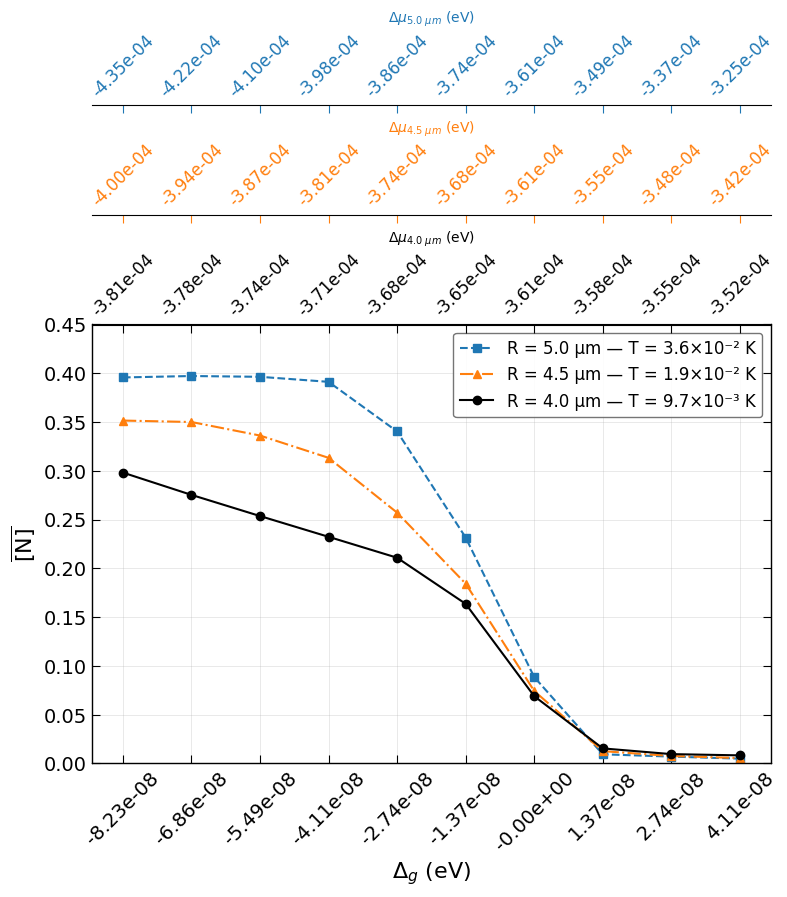

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Load and preprocess data ===
folder_4   = 'qpu_data/production/6x6/4micron'
folder_4_5 = 'qpu_data/production/6x6/4.5micron'
folder_5   = 'qpu_data/production/6x6/5micron'

delta_g_all_int_neg = -np.linspace(125000000, -62500000, 10)

def load_hardware_data(folder):
    datasets = []
    delta_mu_vals = []
    for delta_g_idx in range(10):
        path = os.path.join(folder, str(delta_g_idx))
        preseqs, postseqs = read_all_sequences_from_folder(path)
        datasets.append((preseqs, postseqs, f"Δg = {delta_g_idx}"))

        delta_g = -extract_detuning_values(path)[-1]
        delta_mu = (-reg_coef_rad_s[0] + delta_g * alpha_v)  # optional conversion later
        delta_mu_vals.append(delta_mu)
    return datasets, delta_mu_vals

# --- Load all datasets ---
datasets_4,   delta_mu_vals_4   = load_hardware_data(folder_4)
datasets_4_5, delta_mu_vals_4_5 = load_hardware_data(folder_4_5)
datasets_5,   delta_mu_vals_5   = load_hardware_data(folder_5)

# --- Compute Hamming averages ---
def compute_hamming_stats(datasets):
    hamming_avg_all, hamming_std_all = [], []
    for preseqs, postseqs, label in datasets:
        _, hamming_avg, hamming_std, *_ = get_hamming(preseqs, postseqs)
        hamming_avg_all.append(hamming_avg)
        hamming_std_all.append(hamming_std)
    return np.array(hamming_avg_all), np.array(hamming_std_all)

hamming_avg_4,   hamming_std_4   = compute_hamming_stats(datasets_4)
hamming_avg_4_5, hamming_std_4_5 = compute_hamming_stats(datasets_4_5)
hamming_avg_5,   hamming_std_5   = compute_hamming_stats(datasets_5)

# =====================================================
# Plot
# =====================================================
fig, ax = plt.subplots(figsize=(8, 6))

# Convert Δg to eV units (for x-axis)
x_vals = delta_g_all_int_neg / eV_to_rad_s

# Plot the 3 datasets
ax.plot(
    x_vals, hamming_avg_5 / 78,
    's--', label='R = 5.0 µm — T = 3.6×10⁻² K', color='tab:blue'
)

ax.plot(
    x_vals, hamming_avg_4_5 / 78,
    '^-', linestyle='-.', label='R = 4.5 µm — T = 1.9×10⁻² K', color='tab:orange'
)
ax.plot(
    x_vals, hamming_avg_4 / 78,
    'o-', label='R = 4.0 µm — T = 9.7×10⁻³ K', color='k'
)

# =====================================================
# Axes, labels, and formatting
# =====================================================
ax.set_xlabel(r"$\Delta_g$ (eV)", fontsize=16)
ax.set_ylabel(r"$\overline{[\text{N}]}$", fontsize=16)
ax.set_ylim([0, 0.4])

# Set same x ticks and formatting as in your previous plots
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.tick_params(
    axis='both', which='both',
    direction='in', top=True, right=True,
    labelsize=14, length=6
)
ax.grid(True, which='both', linewidth=0.5, alpha=0.4)

# Add legend — same aesthetic as before
ax.legend(
    loc='best',
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='0.4',
    framealpha=0.9,
)

# Set x limits with padding
xmin = x_vals.min() - 0.05 * (x_vals.max() - x_vals.min())
xmax = x_vals.max() + 0.05 * (x_vals.max() - x_vals.min())
ax.set_xlim(xmin, xmax)
ax.set_ylim(0,0.45)
ax.set_xticks(x_vals)
ax.set_xticklabels([f"{x:.2e}" for x in x_vals],rotation=45)
ax.grid(True, axis='x', which='both', linewidth=0.5, alpha=0.4)
plt.tight_layout()

# ---- helper to add a colored top axis for one curve ----
def add_mu_top_axis(ax_base, x_vals_bottom, delta_g_rad_s, alpha_v, reg0_rad_s,
                    eV_to_rad_s, color, y_offset_axes=1.0, label=r"$\Delta\mu$ (eV)"):
    """
    ax_base: the main axes
    x_vals_bottom: tick positions on the bottom axis (Δg/eV_to_rad_s)
    delta_g_rad_s: the actual hardware Δg for those points (rad/s), same order as x_vals_bottom
    alpha_v, reg0_rad_s: calibration for this curve
    eV_to_rad_s: unit conversion
    color: tick/label color to match the line
    y_offset_axes: where to place this extra axis (1.00=top of axes; >1 stacks above)
    """
    # map Δg -> Δμ
    delta_mu = (-reg0_rad_s + alpha_v * delta_g_rad_s) / eV_to_rad_s  # eV
    print(alpha_v,delta_mu[-1]-delta_mu[0])
    # make a new twiny and lift it slightly above the previous one
    ax_top = ax_base.twiny()
    ax_top.set_xlim(ax_base.get_xlim())
    ax_top.set_xticks(x_vals_bottom)
    ax_top.set_xticklabels([f"{m:.2e}" for m in delta_mu], rotation=45)

    # move this spine upward (stacking multiple top axes)
    ax_top.spines["top"].set_position(("axes", y_offset_axes))
    ax_top.tick_params(axis='x', colors=color, direction='in', length=6, labelsize=12,rotation=45)
    ax_top.xaxis.label.set_color(color)
    ax_top.grid(False)
    ax_top.set_xlabel(label, labelpad=6)
    return ax_top

# ---- build Δg (rad/s) arrays that correspond to your bottom ticks ----
# you already have bottom ticks as x_vals = delta_g_all_int_neg / eV_to_rad_s
delta_g_rad_s_points = x_vals * eV_to_rad_s  # same for all since bottom ticks use common Δg values

# If each curve has different calibration, specify them here; otherwise reuse the same.
(alpha_4, reg0_4)     = (alpha_v_4, reg_coef_rad_s[0])
(alpha_4_5, reg0_4_5) = (alpha_v_4_5, reg_coef_rad_s[0])
(alpha_5, reg0_5)     = (alpha_v_5, reg_coef_rad_s[0])

# stack three colored top axes (slightly separated vertically)
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_4,   reg0_4,   eV_to_rad_s, color='k',          y_offset_axes=1.00, label=r"$\Delta\mu_{4.0\ \mu m}$ (eV)")
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_4_5, reg0_4_5, eV_to_rad_s, color='tab:orange', y_offset_axes=1.25, label=r"$\Delta\mu_{4.5\ \mu m}$ (eV)")
_ = add_mu_top_axis(ax, x_vals, delta_g_rad_s_points, alpha_5,   reg0_5,   eV_to_rad_s, color='tab:blue',   y_offset_axes=1.5, label=r"$\Delta\mu_{5.0\ \mu m}$ (eV)")

plt.show()

## Visualise structures

In [49]:
def extract_binary_vectors_from_datasets(datasets):
    """
    Extract post-measurement bitstrings ONLY for shots where presequence
    indicates all atoms were present.

    Args:
        datasets: List of (preseqs, postseqs, label) as produced by load_hardware_data.

    Returns:
        np.array of shape (num_valid_shots_total, num_atoms)
        containing only post-measurement bitstrings from well-prepared shots.
    """
    collected = []

    for preseqs, postseqs, label in datasets:
        preseqs  = np.array(preseqs)
        postseqs = np.array(postseqs)

        # Skip malformed entries
        if preseqs.ndim != 2 or postseqs.ndim != 2:
            continue
        if preseqs.shape[1] != postseqs.shape[1]:
            continue

        num_atoms = preseqs.shape[1]

        # Keep only shots where ALL atoms were present in the pre-sequence
        mask = (preseqs.sum(axis=1) == num_atoms)

        post_good = postseqs[mask]

        # Store only good post bitstrings
        for vec in post_good:
            collected.append(vec.astype(int))

    return np.array(collected)

In [58]:
vecs = extract_binary_vectors_from_datasets(datasets_5)
print(vecs.shape)
print(vecs[:1][0])
print(np.where(vecs[:1][0]==1)[0])

(7487, 78)
[0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1
 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 1 0]
[ 1  2  4  6  8 10 12 13 14 16 18 19 21 23 24 26 28 30 32 33 35 36 37 40
 42 44 45 46 47 49 51 53 55 56 58 60 61 63 64 65 67 69 71 73 75 76]


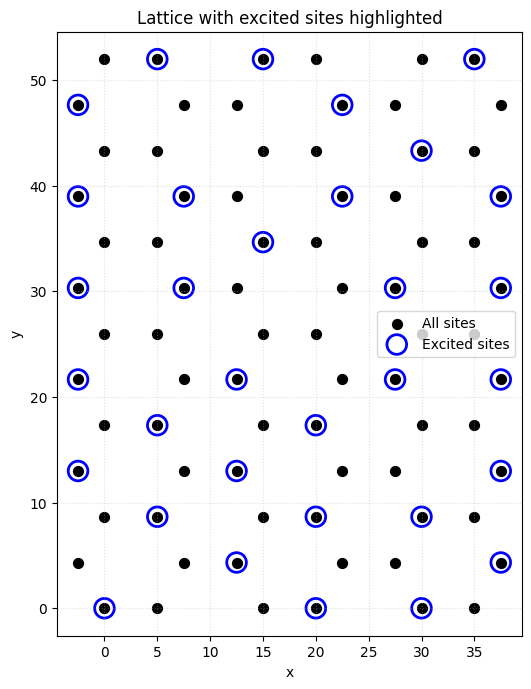

In [87]:
import numpy as np
from ase import Atoms

coords = np.array([
[0.000000,0.000000],
[-2.500000,4.330127],
[0.000000,8.660254],
[-2.500000,12.990381],
[0.000000,17.320508],
[-2.500000,21.650635],
[0.000000,25.980762],
[-2.500000,30.310889],
[0.000000,34.641016],
[-2.500000,38.971143],
[0.000000,43.301270],
[-2.500000,47.631397],
[0.000000,51.961524],
[5.000000,0.000000],
[7.500000,4.330127],
[5.000000,8.660254],
[7.500000,12.990381],
[5.000000,17.320508],
[7.500000,21.650635],
[5.000000,25.980762],
[7.500000,30.310889],
[5.000000,34.641016],
[7.500000,38.971143],
[5.000000,43.301270],
[7.500000,47.631397],
[5.000000,51.961524],
[15.000000,0.000000],
[12.500000,4.330127],
[15.000000,8.660254],
[12.500000,12.990381],
[15.000000,17.320508],
[12.500000,21.650635],
[15.000000,25.980762],
[12.500000,30.310889],
[15.000000,34.641016],
[12.500000,38.971143],
[15.000000,43.301270],
[12.500000,47.631397],
[15.000000,51.961524],
[20.000000,0.000000],
[22.500000,4.330127],
[20.000000,8.660254],
[22.500000,12.990381],
[20.000000,17.320508],
[22.500000,21.650635],
[20.000000,25.980762],
[22.500000,30.310889],
[20.000000,34.641016],
[22.500000,38.971143],
[20.000000,43.301270],
[22.500000,47.631397],
[20.000000,51.961524],
[30.000000,0.000000],
[27.500000,4.330127],
[30.000000,8.660254],
[27.500000,12.990381],
[30.000000,17.320508],
[27.500000,21.650635],
[30.000000,25.980762],
[27.500000,30.310889],
[30.000000,34.641016],
[27.500000,38.971143],
[30.000000,43.301270],
[27.500000,47.631397],
[30.000000,51.961524],
[35.000000,0.000000],
[37.500000,4.330127],
[35.000000,8.660254],
[37.500000,12.990381],
[35.000000,17.320508],
[37.500000,21.650635],
[35.000000,25.980762],
[37.500000,30.310889],
[35.000000,34.641016],
[37.500000,38.971143],
[35.000000,43.301270],
[37.500000,47.631397],
[35.000000,51.961524],
])
coords_3d = np.hstack([coords, np.zeros((coords.shape[0], 1))])
# scale to NN = 1.425 Å
scale_factor = 1.425 / 5.0
coords_scaled = coords_3d * scale_factor



# vec we use:
vec = vecs[:1][0]   # length = number of atoms

# find indices where excited atoms occur
excited_idx = np.where(vec == 0)[0]
atomic_num = np.array([6] * 78)
atomic_num[excited_idx] = 7
structure = Molecule(atomic_num,coords_scaled)
structure.to_file('data/structures/graphene_mol_r_6_6_N40.xyz',fmt='xyz')
vview(structure)
# extract positions of those sites
excited_coords = coords[excited_idx]

# --- plot ---
plt.figure(figsize=(6,10))

# all atoms
plt.scatter(coords[:,0], coords[:,1], s=50, color='black', label="All sites")

# excited atoms (blue circles)
plt.scatter(excited_coords[:,0], excited_coords[:,1],
            s=200, facecolors='none', edgecolors='blue', linewidth=2,
            label="Excited sites")

plt.gca().set_aspect('equal', 'box')
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lattice with excited sites highlighted")
plt.show()

In [77]:
((np.sum(vec)-78)/78)*100

-41.02564102564102

In [69]:
preseqs, postseqs = read_all_sequences_from_folder(path)

preseqs = np.array(preseqs)
postseqs = np.array(postseqs)
num_atoms = preseqs.shape[1]

# 1. Keep only shots where the presequence was full (all atoms present)
keep_mask = (np.sum(preseqs, axis=1) == num_atoms)

preseqs_f = preseqs[keep_mask]
vecs_f    = vecs[keep_mask]      # filtered post-sequences

print(f"Total shots: {len(vecs)} | After filtering: {len(vecs_f)}")

# ----------------------------------------------------------
# 2. Find the shot with the *maximum number of zeros*
# ----------------------------------------------------------
zero_counts = np.sum(vecs_f == 0, axis=1)
best_shot_idx = np.argmax(zero_counts)
vec = vecs_f[best_shot_idx]

print(f"Selected filtered shot {best_shot_idx} with {zero_counts[best_shot_idx]} zeros.")

# Indices of zero entries
zero_idx = np.where(vec == 0)[0]

# ----------------------------------------------------------
# 3. Plot lattice + highlight zeros
# ----------------------------------------------------------
plt.figure(figsize=(6, 10))

# all atom coordinates
plt.scatter(coords[:, 0], coords[:, 1], s=50, color="black", label="All sites")

# highlight zero entries (NOT excited)
plt.scatter(
    coords[zero_idx, 0],
    coords[zero_idx, 1],
    s=200,
    facecolors="none",
    edgecolors="blue",
    linewidth=2,
    label="Ground state (0)",
)

plt.gca().set_aspect("equal", "box")
plt.grid(True, linestyle=":", alpha=0.4)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Shot with most zeros (after presequence filtering)")
plt.show()

NameError: name 'path' is not defined

In [41]:
# Majority over *all* 5 µm shots across all detunings:
all_5 = np.vstack(all_postseqs_5)
global_mean = all_5.mean(axis=0)
global_binary_5 = (global_mean >= 0.5).astype(int)
print("Global 5 µm bitstring:")
print(global_binary_5)

Global 5 µm bitstring:
[1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1
 0 1 1 1]


In [48]:
excited_all = 1 - all_5
np.sum(all_5,axis=1)[0:100]


array([46, 45, 49, 46, 47, 47, 49, 46, 47, 47, 48, 47, 48, 45, 49, 46, 51,
       48, 47, 45, 46, 48, 43, 52, 45, 45, 48, 47, 51, 40, 50, 50, 48, 45,
       50, 51, 48, 49, 53, 45, 47, 49, 46, 50, 48, 46, 47, 48, 48, 47, 49,
       48, 50, 48, 46, 46, 44, 46, 50, 49, 50, 47, 49, 47, 43, 46, 48, 45,
       47, 47, 48, 48, 46, 45, 48, 46, 51, 48, 50, 47, 46, 51, 50, 44, 49,
       48, 47, 45, 49, 49, 48, 47, 47, 46, 47, 45, 49, 49, 47, 49])

In [79]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])

graphene_mol_r_6_6 = cut_graphene_rectangle(graphene,15,14,center=True)
graphene_mol_r_6_6.remove_sites([1,5,11,18,25,32])
vview(graphene_mol_r_6_6)
# graphene_mol_r_6_6.to_file('/Users/brunocamino/Desktop/UCL/rydberg_atoms/data/structures/graphene_mol_r_6_6.xyz')
# Add periodic boundary conditions
cell = np.array([[16.04, -2.134, 0.0],
                [ 0.0, 12.8 ,0.0],
                [0.0, 0.0, 10.0]])
graphene_mol_r_6_6_pbc = Structure(cell, graphene_mol_r_6_6.atomic_numbers, 
                                   graphene_mol_r_6_6.cart_coords, coords_are_cartesian=True)

# vview(graphene_mol_r_6_6_pbc)
# graphene_mol_r_6_6_pbc.to_file('/Users/brunocamino/Desktop/UCL/rydberg_atoms/data/structures/graphene_mol_r_6_6.cif')

In [80]:
vec = vecs[:1][0]   # length = number of atoms

# find indices where excited atoms occur
excited_idx = np.where(vec == 0)[0] 
for i in excited_idx:
    graphene_mol_r_6_6_pbc.replace(i,7)

In [81]:
vview(graphene_mol_r_6_6_pbc)

## Success ratio

In [90]:
import os
import numpy as np

ROOT = "/Users/brunocamino/Desktop/UCL/rydberg_atoms/qpu_data/production"


def stack_if_needed(arr):
    """Ensure we always end up with a 2D array (shots × atoms)."""
    arr = np.array(arr)
    if arr.ndim == 3:  # chunked → stack
        arr = np.vstack(arr)
    return arr


def success_ratio_in_folder(folder):
    """
    Returns:
        success_ratio (float),
        num_successful (int),
        num_total (int)
    """
    try:
        preseqs, _ = read_all_sequences_from_folder(folder)
    except Exception:
        return None  # skip unreadable folders

    preseqs = stack_if_needed(preseqs)

    if preseqs.ndim != 2:
        return None

    num_atoms = preseqs.shape[1]

    # successful shots = full presequence
    success_mask = (np.sum(preseqs, axis=1) == num_atoms)

    num_success = np.sum(success_mask)
    num_total = preseqs.shape[0]

    if num_total == 0:
        return None

    return num_success / num_total, num_success, num_total

In [91]:
success_ratios = []
details = []  # optional: keep per-folder info

for root, dirs, files in os.walk(ROOT):
    # leaf folders are the annealing folders (contain numeric subfolders or data)
    if root == ROOT:
        continue

    result = success_ratio_in_folder(root)
    if result is None:
        continue

    ratio, n_success, n_total = result
    success_ratios.append(ratio)
    details.append((root, ratio, n_success, n_total))

In [92]:
success_ratios = np.array(success_ratios)

mean_ratio = np.mean(success_ratios)
std_ratio  = np.std(success_ratios)
min_ratio  = np.min(success_ratios)
max_ratio  = np.max(success_ratios)

print("==== State preparation success statistics ====")
print(f"Number of annealings analysed: {len(success_ratios)}")
print(f"Mean success ratio : {mean_ratio:.3f}")
print(f"Std  success ratio : {std_ratio:.3f}")
print(f"Min  success ratio : {min_ratio:.3f}")
print(f"Max  success ratio : {max_ratio:.3f}")

==== State preparation success statistics ====
Number of annealings analysed: 61
Mean success ratio : 0.605
Std  success ratio : 0.121
Min  success ratio : 0.406
Max  success ratio : 0.814
